In [15]:
import os
import numpy as np
import pandas as pd

import pickle
import json

import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [19]:
base_path = '../Data/tmp/Old/'

visual_json = '../Data/tmp/visualize_pose.json'
pose0_json = base_path + 'example_output_poses_0.json'
pose1_json = base_path + 'example_output_poses_1.json'
pose2_json = base_path + 'example_output_poses_2.json'


with open(visual_json, 'r') as json_file:
    visual_json = json.load(json_file)

with open(pose0_json, 'r') as json_file:
    pose0_json = json.load(json_file)

with open(pose1_json, 'r') as json_file:
    pose1_json = json.load(json_file)

with open(pose2_json, 'r') as json_file:
    pose2_json = json.load(json_file)

In [20]:
def norm1(positionVector):
    magnitude = np.linalg.norm(positionVector)

    if magnitude == 0:
        return np.zeros_like(positionVector)
    
    return (positionVector / magnitude).tolist()

In [21]:
def makeBody(json, visual_json):
    body_dict = {}
    for frame in json:
        if len(frame['landmarks']) == 0:
            continue
        for key, valueList in visual_json.items():
            for value in valueList:
                name = f'{key}-{value}'

                vector = [frame['landmarks'][value]['x'] - frame['landmarks'][int(key)]['x'],
                          frame['landmarks'][value]['y'] - frame['landmarks'][int(key)]['y'],
                          frame['landmarks'][value]['z'] - frame['landmarks'][int(key)]['z']]
                vector = norm1(vector)
                body_dict[name] = body_dict[name] + [vector] if name in body_dict.keys() else [vector]
            
    return body_dict

In [22]:
def dynamicTimeWarpingPart(vector_list1: list, vector_list2: list) -> np.array: 
    # 출력: 신체 부위에 대한 timewarping matrix
    # 입력: vector_list1이 수강생
    array1 = np.transpose(np.array(vector_list1 * len(vector_list2)).reshape(len(vector_list2), len(vector_list1), 3), (1, 0, 2))
    array2 = np.array(vector_list2 * len(vector_list1)).reshape(len(vector_list1), len(vector_list2), 3)

    distance_array = array1 - array2
    distance_array = np.sqrt(np.square(distance_array[:, :, 0]) + np.square(distance_array[:, :, 1]) + np.square(distance_array[:, :, 2]))

    distance_array_origin = distance_array.copy()

    shape1 = distance_array.shape[0]
    shape2 = distance_array.shape[1]

    for i in range(shape1):
        if i == 0:
            continue
        else:
            distance_array[i, 0] += distance_array[i-1, 0]

    for j in range(shape2):
        if j == 0:
            continue
        else:
            distance_array[0, j] += distance_array[0, j-1]
    
    for i in range(1, shape1):
        for j in range(1, shape2):
            distance_array[i, j] += np.min([distance_array[i-1, j],
                                            distance_array[i, j-1],
                                            distance_array[i-1, j-1]])

    return  distance_array, distance_array_origin

In [23]:
def findPath(result_list):
    result = {'shortestPath' : [],
              'shortestScoring' : []
              }

    result_list = np.array(result_list)
    result_sum = np.sum(result_list, axis=0)

    reference_x = result_sum.shape[1]-1 
    reference_y = result_sum.shape[0]-1
    for i in range(result_sum.shape[0]-1, -1, -1):
        for j in range(result_sum.shape[1]-1, -1, -1):
            if (j > reference_x) & (reference_x != 0):
                continue
            elif (reference_x == 0):
                for tmp_i in range(reference_y, -1, -1):
                    result['shortestPath'].append((tmp_i, 0))
                    result['shortestScoring'].append(result_sum[tmp_i, 0])

                result['shortestPath'].reverse()
                result['shortestScoring'].reverse()
                return result_sum, result

            else:
                tmp = [result_sum[i, j-1], result_sum[i-1, j-1], result_sum[i-1, j]]
                index = tmp.index(min(tmp))
                result['shortestPath'].append((i, j))
                result['shortestScoring'].append(result_sum[i, j])
                if index == 0:                    
                    reference_x = j-1
                    continue
                elif index == 1:
                    reference_x = j-1
                    reference_y = i-1
                    break
                else:
                    reference_y = i-1
                    break
    
    result['shortestPath'].reverse()
    result['shortestScoring'].reverse()
    return result_sum, result

In [24]:
def partScoring(result, body_name, result_origin_list):
    for k, name in enumerate(body_name):
        for i, path in enumerate(result['shortestPath']):
            value = result_origin_list[k][path[0]][path[1]]
            value = round(100 - (100 * (np.mean(value) / 2)), 2)
            result[name] = [value] if i == 0 else result[name] + [value]
            
    return result

In [25]:
def score(result):
    df = {}
    for i, key in enumerate(list(result.keys())[2:]):
        if i == 0:
            df['부위'] = [key]        
            df['평균점수'] = [round(np.mean(result[key]), 2)]
        else:
            df['부위'] += [key]
            df['평균점수'] += [round(np.mean(result[key]), 2)]

    df['부위'] += ['전체']
    df['평균점수'] += [round(sum(df['평균점수']) / len(df['평균점수']), 2)]

    return pd.DataFrame(df)

In [26]:
def poseScoring(json1, json2, visual_json):
    body_dict1 = makeBody(json1, visual_json)
    body_dict2 = makeBody(json2, visual_json)

    result_list = []
    result_origin_list = []
    for i, body_part in enumerate(body_dict1.keys()):
        distance_array, distance_array_origin = dynamicTimeWarpingPart(body_dict1[body_part], body_dict2[body_part])
        result_list.append(distance_array)
        result_origin_list.append(distance_array_origin)

    result_sum, result = findPath(result_list)

    body_name = list(body_dict1.keys())
    result = partScoring(result, body_name, result_origin_list)  

    df = score(result)
    
    return result_sum, result, df

In [27]:
result_sum1, result1, df1 = poseScoring(pose0_json, pose1_json, visual_json)
result_sum2, result2, df2 = poseScoring(pose0_json, pose2_json, visual_json)

In [28]:
df1

,부위,평균점수
0,0-1,77.14
1,0-4,77.08
2,1-2,69.28
3,2-3,67.77
4,3-7,75.59
5,4-5,65.96
6,5-6,67.88
7,6-8,76.51
8,9-10,70.11
9,11-12,72.90


In [29]:
df2

,부위,평균점수
0,0-1,80.82
1,0-4,79.87
2,1-2,81.98
3,2-3,80.68
4,3-7,79.73
5,4-5,81.25
6,5-6,78.35
7,6-8,80.07
8,9-10,77.13
9,11-12,78.19


### 시각화

In [30]:
with open('../Result/tmp/tmp1.pickle', 'wb') as file:
    pickle.dump([result_sum1, result1, df1], file)

with open('../Result/tmp/tmp2.pickle', 'wb') as file:
    pickle.dump([result_sum2, result2, df2], file)

Text(0, 0.5, '수강생자세')

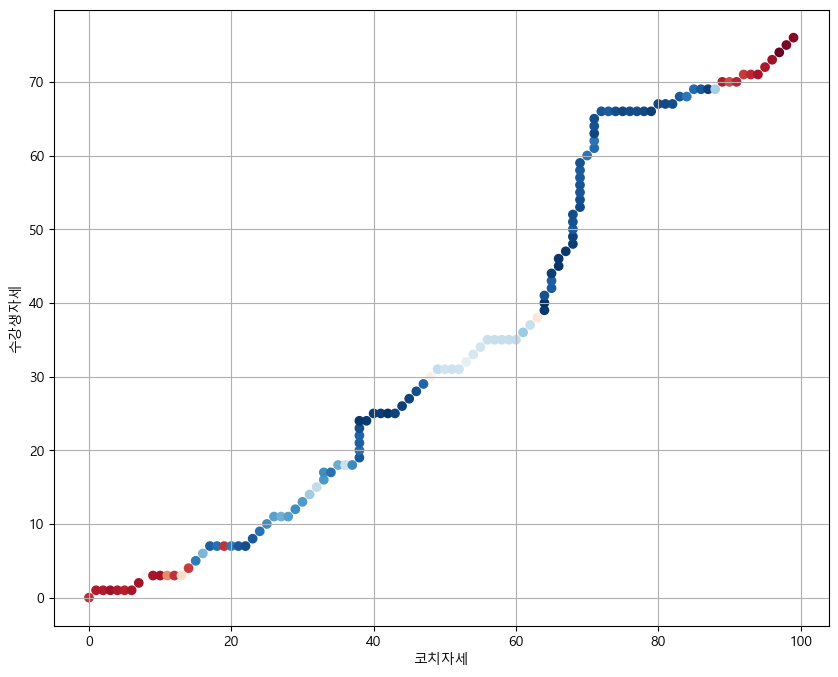

In [32]:
value = np.zeros(len(result1['12-14']))
body_list = list(result1.keys())[2:] 

for key in body_list:
    value += np.array(result1[key])

value = value / len(body_list)

x_list = []
y_list = []

for coordinate in result1['shortestPath']:
    x_list.append(coordinate[0])
    y_list.append(coordinate[1])


fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(x_list, y_list, c = value, cmap = 'RdBu')
ax.grid(True)
ax.set_xlabel('코치자세')
ax.set_ylabel('수강생자세')


Text(0, 0.5, '수강생자세')

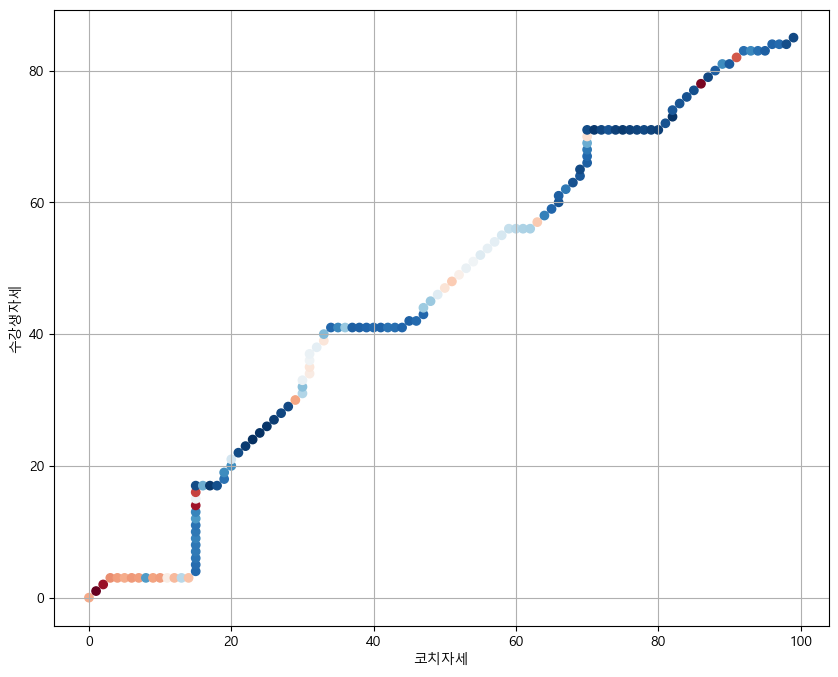

In [33]:
value = np.zeros(len(result2['shortestScoring']))
body_list = list(result2.keys())[2:] 

for key in body_list:
    value += np.array(result2[key])

value = value / len(body_list)

x_list = []
y_list = []

for coordinate in result2['shortestPath']:
    x_list.append(coordinate[0])
    y_list.append(coordinate[1])


fig, ax = plt.subplots(figsize = (10, 8))

ax.scatter(x_list, y_list, c = value, cmap = 'RdBu')
ax.grid(True)
ax.set_xlabel('코치자세')
ax.set_ylabel('수강생자세')
